# Comparison to the Water Budget

We want to compare the changes of our reconstructed water storage anomalies to the water balance equation, calculated from ERA5.

In [ ]:
import string

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from dask.diagnostics import ProgressBar
from matplotlib import ticker
from matplotlib_inline.backend_inline import set_matplotlib_formats

import deepwaters  # noqa
from deepwaters import metrics
from deepwaters.regions import basins
from deepwaters.utils import ROOT_DIR
from deepwaters.visualization import plot_basinwise_map

# Register dask progress bar
ProgressBar(minimum=5).register()


In [ ]:
set_matplotlib_formats("retina")
plt.style.use(ROOT_DIR / "config/style_paper.mplstyle")
FIGURE_DIR = ROOT_DIR / "docs/figures/paper"


## Data Loading

For preprocessing, see the corresponding notebook [here](./3.1-water-budget-preprocessing.ipynb).

In [ ]:
twsc_path = ROOT_DIR / "data/evaluations/twsc_basin-scale.zarr"
twsc = xr.open_zarr(twsc_path)


Specify variables of interest and their descriptive names:

In [4]:
# shorten name of our reconstruction
twsc = twsc.rename(pred_ensemble_alltrain_nogap_lnll_latest="our")


In [ ]:
vars_verbose = {
    "our": "DeepWaters (Ours)",
    "gap": "WGHM",
    "humphrey_gsfc_detrend": "Humphrey's GSFC Rec",
    "li_csr_full": "Li's CSR Rec",
    "yin_csr_full": "Yin's CSR Rec",
    "csr": "CSR (GRACE)",
}
bdgt_name = "era5_smooth"
grace_name = "csr"
our_name = "our"
eval_names = vars_verbose.keys()


## Analysis

Define evaluation models and water balance target:

In [6]:
# Drop all time steps where one variable is NaN
twsc_post = twsc.where(twsc.dw.time_notnull("region"), drop=True)

bdgt_post = twsc_post[bdgt_name]
eval_post = twsc_post[eval_names].to_dataarray("model")

twsc_post


<xarray.Dataset> Size: 997kB
Dimensions:                                 (region: 72, time: 192)
Coordinates:
  * region                                  (region) object 576B 'Congo' ... ...
  * time                                    (time) datetime64[ns] 2kB 2002-05...
Data variables:
    csr                                     (region, time) float64 111kB dask.array<chunksize=(72, 192), meta=np.ndarray>
    era5                                    (region, time) float64 111kB dask.array<chunksize=(72, 192), meta=np.ndarray>
    era5_smooth                             (region, time) float64 111kB dask.array<chunksize=(72, 192), meta=np.ndarray>
    gap                                     (region, time) float64 111kB dask.array<chunksize=(72, 192), meta=np.ndarray>
    humphrey_gsfc_detrend                   (region, time) float64 111kB dask.array<chunksize=(72, 192), meta=np.ndarray>
    li_csr_full                             (region, time) float64 111kB dask.array<chunksize=(72, 192), meta=np.ndarray>
    pred_ensemble_alltrain_gap_lnll_latest  (region, time) float64 111kB dask.array<chunksize=(72, 192), meta=np.ndarray>
    our                                     (region, time) float64 111kB dask.array<chunksize=(72, 192), meta=np.ndarray>
    yin_csr_full                            (region, time) float64 111kB dask.array<chunksize=(72, 192), meta=np.ndarray>

In [7]:
twsc_pre = twsc.sel(time=slice("1980", "2002-03"))

bdgt_pre = twsc_pre[bdgt_name]
eval_pre = twsc_pre[eval_names].drop_vars(grace_name).to_dataarray("model")

twsc_pre


<xarray.Dataset> Size: 1MB
Dimensions:                                 (region: 72, time: 267)
Coordinates:
  * region                                  (region) object 576B 'Congo' ... ...
  * time                                    (time) datetime64[ns] 2kB 1980-01...
Data variables:
    csr                                     (region, time) float64 154kB dask.array<chunksize=(72, 267), meta=np.ndarray>
    era5                                    (region, time) float64 154kB dask.array<chunksize=(72, 267), meta=np.ndarray>
    era5_smooth                             (region, time) float64 154kB dask.array<chunksize=(72, 267), meta=np.ndarray>
    gap                                     (region, time) float64 154kB dask.array<chunksize=(72, 267), meta=np.ndarray>
    humphrey_gsfc_detrend                   (region, time) float64 154kB dask.array<chunksize=(72, 267), meta=np.ndarray>
    li_csr_full                             (region, time) float64 154kB dask.array<chunksize=(72, 267), meta=np.ndarray>
    pred_ensemble_alltrain_gap_lnll_latest  (region, time) float64 154kB dask.array<chunksize=(72, 267), meta=np.ndarray>
    our                                     (region, time) float64 154kB dask.array<chunksize=(72, 267), meta=np.ndarray>
    yin_csr_full                            (region, time) float64 154kB dask.array<chunksize=(72, 267), meta=np.ndarray>

###  Calculate RMSE

In [ ]:
rmse_pre = metrics.rmse(bdgt_pre, eval_pre, dim="time").compute()
rmse_post = metrics.rmse(bdgt_post, eval_post, dim="time").compute()

# Select our reconstruction and GRACE
our_rmse_pre = rmse_pre.sel(model=our_name)
our_rmse_post = rmse_post.sel(model=our_name)
csr_rmse_post = rmse_post.sel(model=grace_name)


### Calculate NSE

In [ ]:
nse_pre = metrics.nse(bdgt_pre, eval_pre, dim="time").compute()
nse_post = metrics.nse(bdgt_post, eval_post, dim="time").compute()

# Select our reconstruction and GRACE
our_nse_pre = nse_pre.sel(model=our_name)
our_nse_post = nse_post.sel(model=our_name)
csr_nse_post = nse_post.sel(model=grace_name)


## Create Plot

In [ ]:
rmse_kwargs = dict(
    cmap="viridis",
    rasterized=True,
    vmin=0,
    vmax=50,
    # levels=11,
    add_colorbar=False,
    cbar_kwargs=None,
    zorder=2,
)
nse_kwargs = dict(
    cmap="PiYG",
    rasterized=True,
    vmin=-1,
    vmax=1,
    # levels=9,
    add_colorbar=False,
    cbar_kwargs=None,
    zorder=2,
)
basinlines_kwargs = dict(
    edgecolor="black",
    linewidth=0.5,
    facecolor="None",
    rasterized=True,
)
rmse_cbar_kwargs = dict(location="bottom", aspect=50, shrink=0.66)
nse_cbar_kwargs = dict(location="bottom", aspect=50, shrink=0.66, extend="min")


In [11]:
# Get timespan
start = eval_post.get_index("time")[0]
end = eval_post.get_index("time")[-1]
timespan_str = f"{start.year}-{start.month:02} - {end.year}-{end.month:02}"
timespan_str


'2002-05 - 2019-06'

In [ ]:
# Create a spatial dummy array for the plot_basinwise_map() function
STEP_DEG = 0.5
lats = np.arange(-89.75, 89.75 + STEP_DEG, STEP_DEG)
lons = np.arange(-179.75, 179.75 + STEP_DEG, STEP_DEG)

ones = np.ones([len(lats), len(lons)])

spatial_dummy = xr.DataArray(ones, coords={"lat": lats, "lon": lons})


In [13]:
basin_shapes = basins(top=72)

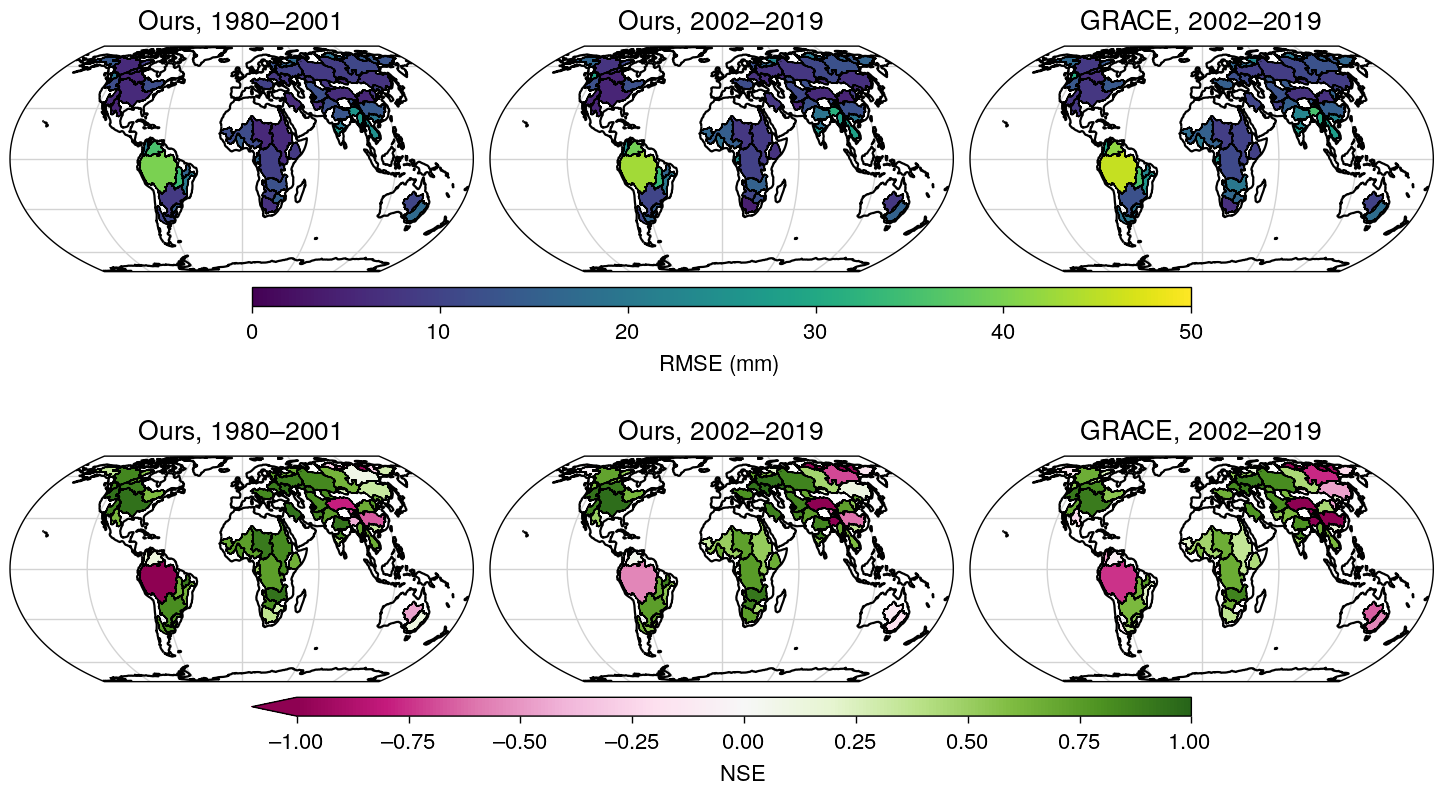

In [14]:
# Subfigure approach
fig = plt.figure(figsize=(7.2, 4))
subfigs = fig.subfigures(nrows=2, hspace=0.05)

axs_rmse = subfigs[0].subplots(1, 3, subplot_kw={"projection": ccrs.EqualEarth()})
axs_nse = subfigs[1].subplots(1, 3, subplot_kw={"projection": ccrs.EqualEarth()})

axs_geo = [*axs_rmse, *axs_nse]

# Add gridlines
for ax in axs_geo:
    ax.gridlines(zorder=1)

# RMSE Ours Pre-GRACE
p_rmse = plot_basinwise_map(our_rmse_pre, spatial_dummy, ax=axs_rmse[0], **rmse_kwargs)
axs_rmse[0].set(title="Ours, 1980--2001")

# RMSE Ours GRACE era
plot_basinwise_map(our_rmse_post, spatial_dummy, ax=axs_rmse[1], **rmse_kwargs)
axs_rmse[1].set(title="Ours, 2002--2019")

# RMSE GRACE
plot_basinwise_map(csr_rmse_post, spatial_dummy, ax=axs_rmse[2], **rmse_kwargs)
axs_rmse[2].set(title="GRACE, 2002--2019")

# NSE Ours Pre-GRACE
p_nse = plot_basinwise_map(our_nse_pre, spatial_dummy, ax=axs_nse[0], **nse_kwargs)
axs_nse[0].set(title="Ours, 1980--2001")

# NSE Ours GRACE era
plot_basinwise_map(our_nse_post, spatial_dummy, ax=axs_nse[1], **nse_kwargs)
axs_nse[1].set(title="Ours, 2002--2019")

# NSE GRACE
plot_basinwise_map(csr_nse_post, spatial_dummy, ax=axs_nse[2], **nse_kwargs)
axs_nse[2].set(title="GRACE, 2002--2019")

for ax in axs_geo:
    # Add basinlines
    basin_shapes.dw.projplot(ax=ax, zorder=3, **basinlines_kwargs)
    # Add coastlines
    ax.coastlines(rasterized=True, zorder=4)

# Add colorbars
subfigs[0].colorbar(p_rmse, ax=axs_rmse, label="RMSE (mm)", **rmse_cbar_kwargs)
subfigs[0].colorbar(p_nse, ax=axs_nse, label="NSE", **nse_cbar_kwargs)

fig.savefig(FIGURE_DIR / "bdgt_closure_map.pdf", backend="pgf")


## Weighted Boxplot: Ability to close the water budget

We calculate the error between the reconstructed TWSC and the ERA5 TWSC (the budget). We plot the basin wise errors as a boxplot, whereby we weight the basins according to their approximate size.

In [ ]:
# Create DataArrays for the models to evaluate and the budget
da_eval = twsc[eval_names].to_dataarray("model")
da_bdgt = twsc[bdgt_name]


Create a DataFrame with an integer column where the number is relative to the the basin area. Our weighting function requires integer values.

In [16]:
# Create a DataFrame with the basin shape areas
basin_sizes = basin_shapes[["river", "sum_sub_ar"]].rename(
    columns={"river": "region", "sum_sub_ar": "area"}
)
# Smallest int equals multiplier (specifies accuracy fo the weighting)
MULT = 10
area_rel = basin_sizes.area / basin_sizes.area.min() * MULT
basin_sizes["area_int"] = area_rel.round().astype(int)
basin_sizes


,region,area,area_int
0,Amazon,5965893.5,283
1,Congo,3705225.4,176
2,Nile,3353204.0,159
3,Mississippi,3240620.1,154
4,Ob,3040604.1,144
...,...,...,...
67,Har,229005.7,11
68,Liao,220125.2,10
69,Olenek,217723.1,10
70,Ogooue,215213.0,10


Define the weighting function. We achieve this by creating a function that repeats basins (rows) by an integer number proportional to their size.

In [ ]:
def repeat_by_weight(df: pd.DataFrame, weight_col: str):
    """Repeat rows according to the integer values of a weight column"""
    df = df.reindex(df.index.repeat(df[weight_col])).reset_index(drop=True)
    return df


### Create the boxplot

In [18]:
colors = sns.color_palette("tab10")
colors


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [ ]:
# Create dictionaries for color lookup
colors_dict = {
    "our": colors[0],
    "csr": colors[1],
    "gap": colors[2],
    "humphrey_gsfc_detrend": colors[6],
    "li_csr_full": colors[3],
    "yin_csr_full": colors[4],
}


In [ ]:
# Time periods for calculating basin wise errors
TIME_PERIODS = [
    ("1940", "1959"),
    ("1960", "1979"),
    ("1980", "2002-03"),
    ("2002-04", "2019"),
]


In [ ]:
# DataFrame of the weighted basin RMSEs for every period
df_errors = []

for period in TIME_PERIODS:
    # Select current time period
    da_bdgt_period = da_bdgt.sel(time=slice(*period))
    da_eval_period = da_eval.sel(time=slice(*period))

    # Remove variables which are NA for most of the time
    THRES = 0.5
    n_time = len(da_eval_period.time)
    for model in da_eval_period.model.values:
        # Drop model if less not-NA timesteps than threshold for current period
        n_time_notna = len(
            da_eval_period.sel(model=model).dropna("time", how="all").time
        )
        if n_time_notna < 0.5 * n_time:
            da_eval_period = da_eval_period.drop_sel(model=model)

    # Calculate the RMSE
    da_error = metrics.rmse(da_bdgt_period, da_eval_period, dim="time", skipna=True)
    # Convert to data frame
    df_error = da_error.to_pandas().unstack().reset_index(name="error")
    # Merge with basin frame
    df_error = df_error.merge(basin_sizes)
    # Add decriptive names
    df_error["model_verbose"] = df_error["model"].map(vars_verbose)
    # Repeat rows according to the basin size
    df_error = repeat_by_weight(df_error, weight_col="area_int")

    df_errors.append(df_error)


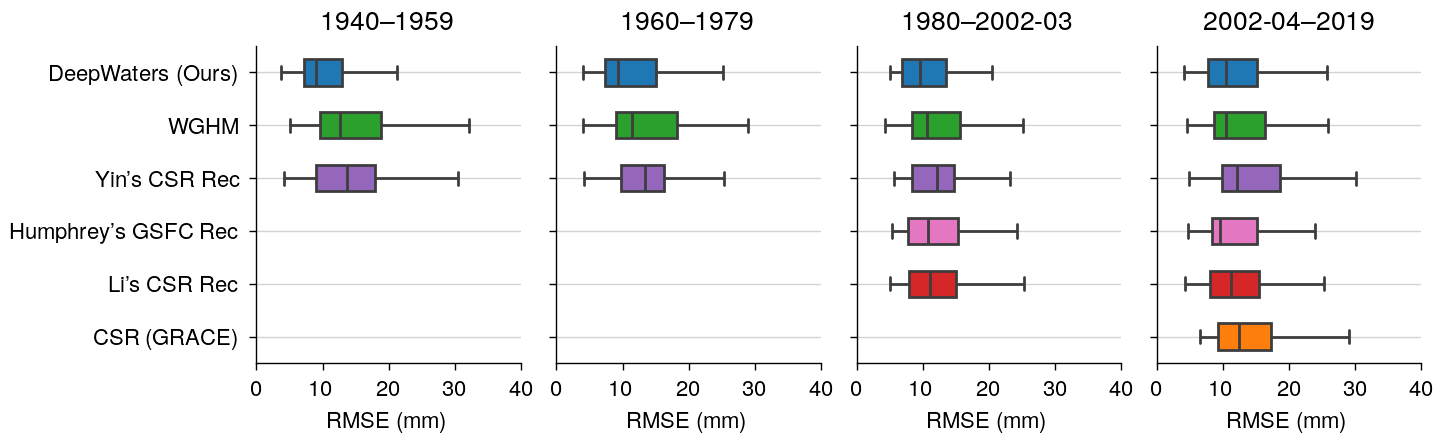

In [22]:
# Create boxplots
fig, axs = plt.subplots(
    ncols=len(TIME_PERIODS), sharex=True, sharey=True, figsize=(7.2, 2.2)
)
locator = ticker.MultipleLocator(10)

# Iterate over different time periods
for ax, period, df_error in zip(axs, TIME_PERIODS, df_errors):
    # Plot
    sns.boxplot(
        df_error,
        x="error",
        y="model_verbose",
        hue="model",
        palette=colors_dict,
        showfliers=False,
        width=0.5,
        saturation=1,
        legend=False,
        ax=ax,
    )
    ax.yaxis.grid()
    ax.set(xlabel="RMSE (mm)", ylabel=None)
    ax.set_title(period[0] + "--" + period[1])
    ax.xaxis.set_major_locator(locator)

axs[0].set(xlim=(0, 40))

fig.savefig(FIGURE_DIR / "bdgt_closure_boxplot.pdf", backend="pgf")


## Combine Everything

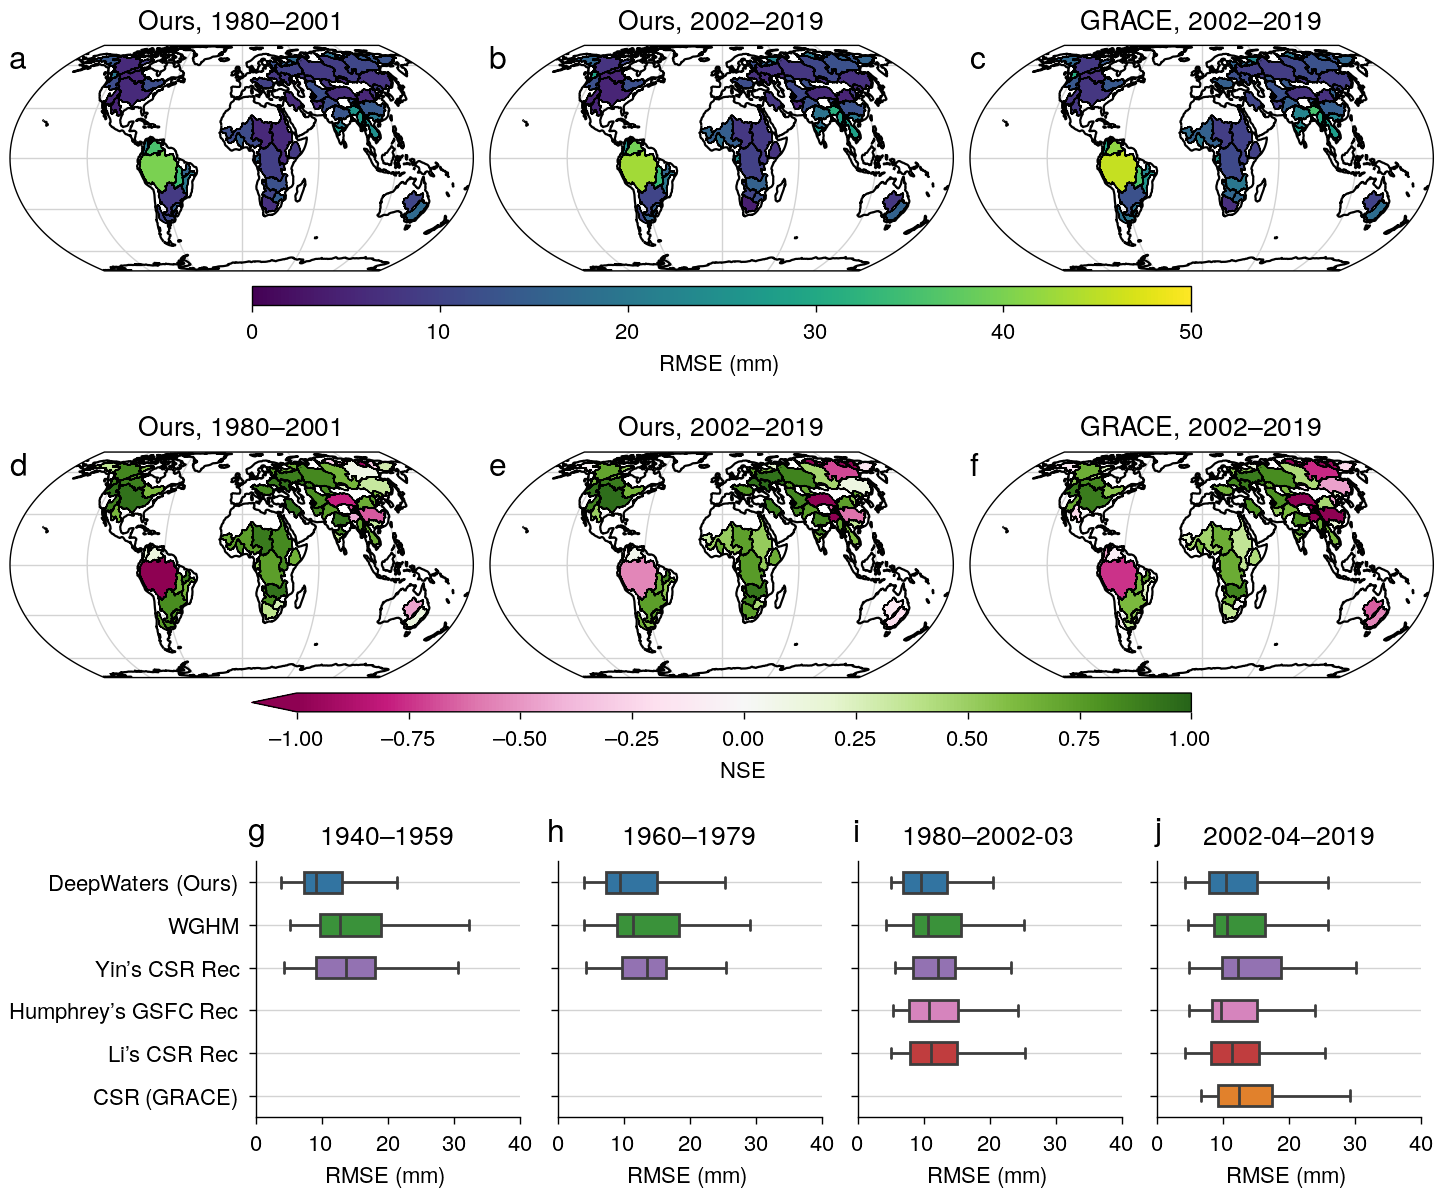

In [23]:
# Subfigure approach
fig = plt.figure(figsize=(7.2, 6))
subfigs = fig.subfigures(nrows=3, hspace=0.05)

axs_rmse = subfigs[0].subplots(1, 3, subplot_kw={"projection": ccrs.EqualEarth()})
axs_nse = subfigs[1].subplots(1, 3, subplot_kw={"projection": ccrs.EqualEarth()})
axs_box = subfigs[2].subplots(1, 4, sharex=True, sharey=True)

axs_geo = [*axs_rmse, *axs_nse]

# Add gridlines
for ax in axs_geo:
    ax.gridlines(zorder=1)

# RMSE Ours Pre-GRACE
p_rmse = plot_basinwise_map(our_rmse_pre, spatial_dummy, ax=axs_rmse[0], **rmse_kwargs)
axs_rmse[0].set(title="Ours, 1980--2001")

# RMSE Ours GRACE era
plot_basinwise_map(our_rmse_post, spatial_dummy, ax=axs_rmse[1], **rmse_kwargs)
axs_rmse[1].set(title="Ours, 2002--2019")

# RMSE GRACE
plot_basinwise_map(csr_rmse_post, spatial_dummy, ax=axs_rmse[2], **rmse_kwargs)
axs_rmse[2].set(title="GRACE, 2002--2019")

# NSE Ours Pre-GRACE
p_nse = plot_basinwise_map(our_nse_pre, spatial_dummy, ax=axs_nse[0], **nse_kwargs)
axs_nse[0].set(title="Ours, 1980--2001")

# NSE Ours GRACE era
plot_basinwise_map(our_nse_post, spatial_dummy, ax=axs_nse[1], **nse_kwargs)
axs_nse[1].set(title="Ours, 2002--2019")

# NSE GRACE
plot_basinwise_map(csr_nse_post, spatial_dummy, ax=axs_nse[2], **nse_kwargs)
axs_nse[2].set(title="GRACE, 2002--2019")

for ax in axs_geo:
    # Add basinlines
    basin_shapes.dw.projplot(ax=ax, zorder=3, **basinlines_kwargs)
    # Add coastlines
    ax.coastlines(rasterized=True, zorder=4)

# Add colorbars
subfigs[0].colorbar(p_rmse, ax=axs_rmse, label="RMSE (mm)", **rmse_cbar_kwargs)
subfigs[0].colorbar(p_nse, ax=axs_nse, label="NSE", **nse_cbar_kwargs)

# Boxplots
for ax, period, df_error in zip(axs_box, TIME_PERIODS, df_errors):
    # Plot
    sns.boxplot(
        df_error,
        x="error",
        y="model_verbose",
        hue="model",
        palette=colors_dict,
        showfliers=False,
        width=0.5,
        # saturation=1,
        legend=False,
        ax=ax,
    )
    ax.set(xlabel="RMSE (mm)", ylabel=None, title=f"{period[0]}--{period[1]}")
    ax.yaxis.grid()
    ax.xaxis.set_major_locator(locator)

axs_box[0].set(xlim=(0, 40))

# Add letters
for n, ax in enumerate(axs_geo):
    ax.text(
        0.0,
        1.0 - 0.10,
        string.ascii_lowercase[n],
        transform=ax.transAxes,
        size="x-large",
        weight="bold",
    )
for n, ax in enumerate(axs_box):
    ax.text(
        0.0,
        1.0 + 0.08,
        string.ascii_lowercase[n + len(axs_geo)],
        ha="center",
        transform=ax.transAxes,
        size="x-large",
        weight="bold",
    )

fig.savefig(FIGURE_DIR / "bdgt_closure.pdf", backend="pgf")
